# Filaments


In [13]:
import os
import re

import numpy as np
import cv2 as cv
from astropy.io import fits
import astropy.units as u
from astropy.table import QTable
from skimage import measure


import matplotlib.pyplot as plt 

from climso.utils import toSunpyMap, medianFlatten, get_mu

In [14]:
base_dir='Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/'
files = [base_dir+file for file in os.listdir(base_dir) if file.startswith('imoa_06563_l1_')] 

def extract_timestamp(file_path):
    match = re.search(r'\d{8}_\d{8}', file_path)
    if match:
        return match.group(0)
    return ''

files = sorted(files, key=extract_timestamp)
    
files

['Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_05522700_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_05562328_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_05575322_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_06002692_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_06042244_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_06085734_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_06110786_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_06124679_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_06134572_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-06-21/imoa_06563_l1_20240621_06164763_emi1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/20

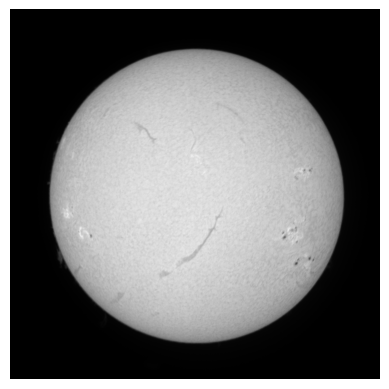

In [15]:
with fits.open(files[0]) as hdul:
    plt.imshow(hdul[0].data, cmap='grey')
    plt.axis('off');

In [16]:
map = toSunpyMap(files[0])

flattened = medianFlatten(map)
mask = np.zeros(map.data.shape, dtype=np.uint8)
cv.circle(mask, (1024,1024), int(map.meta['rsun_obs']-10), 1, thickness=-1)
flattened[mask==0]=np.nan

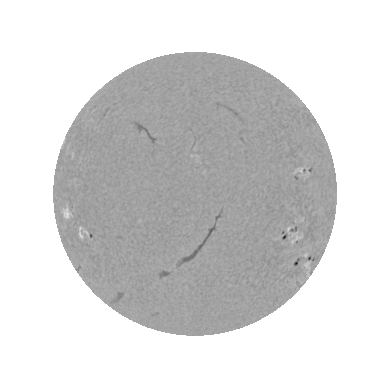

In [468]:
plt.imshow(flattened, origin='lower', cmap='grey')
plt.axis('off');

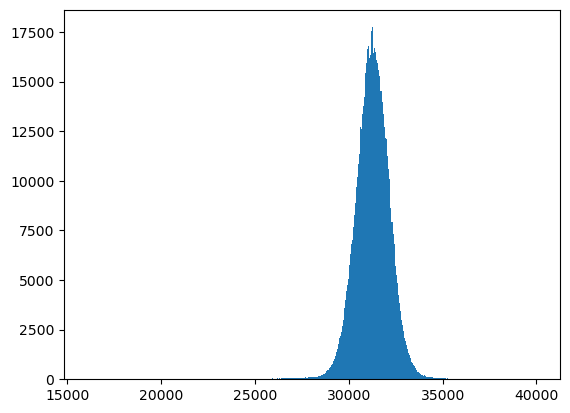

In [469]:
plt.hist(flattened.flatten(), bins='auto');

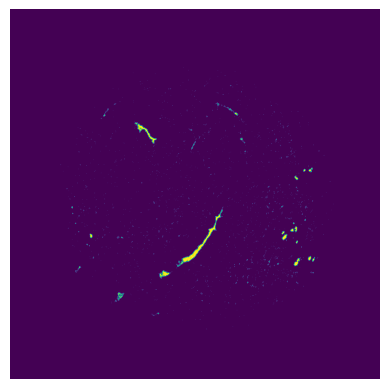

In [470]:
upper_thresh = 0.92*np.nanmedian(flattened)
binary_image = (flattened<upper_thresh).astype(np.uint8)

plt.imshow(binary_image, origin='lower')
plt.axis('off');

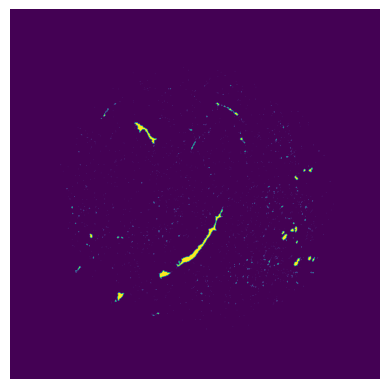

In [471]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
binary_image = cv.morphologyEx(binary_image.astype(np.uint8), cv.MORPH_CLOSE, kernel)
#binary_image = cv.morphologyEx(binary_image.astype(np.uint8), cv.MORPH_OPEN, kernel)

plt.imshow(binary_image, origin='lower')
plt.axis('off');

0.11723045359573533
0.05449555411785887
0.3433943933368915
0.3949709596348992


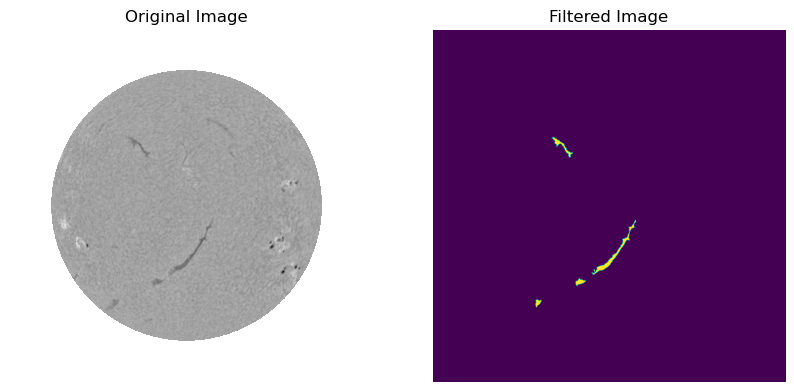

In [473]:
contours, _ = cv.findContours(binary_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Create an empty mask to draw the filtered contours
filaments = np.zeros_like(binary_image)

# check if contour is of circular shape
for contour in contours:
    perimeter = cv.arcLength(contour, True)
    area = cv.contourArea(contour)
    if perimeter < 150:
        continue
    circularity = (area/(perimeter*perimeter))
    if circularity < 0.4 * 0.08: # 0.08 is aprox 1/(4*pi)
        cv.drawContours(filaments, [contour], -1, (255), thickness=cv.FILLED)
        print(circularity*4*3.14)

# Display the original and filtered images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(flattened, origin='lower', cmap='grey')
plt.axis('off');

plt.subplot(1, 2, 2)
plt.title("Filtered Image")
plt.imshow(filaments, origin='lower')
plt.axis('off');


In [474]:
_, labels, _, centroids = cv.connectedComponentsWithStats(filaments, connectivity=8)
centroids=centroids[1:]

In [479]:
regions = measure.regionprops(labels)

radius = map.meta['RSUN_OBS']
mu = get_mu(map)

num  = []
lat  = []
lon  = []
x    = []
y    = []
area = []

for r in regions:
    point = map.pixel_to_world(r.centroid[1]*u.pixel, r.centroid[0]*u.pixel).heliographic_stonyhurst
    lat.append(round(point.lat.deg, 2))
    lon.append(round(point.lon.deg, 2))
    
    num.append(r.label)
    x.append(int(r.centroid[1]))
    y.append(int(r.centroid[0]))
    
    area.append(round((np.sum(labels == r.label) / (2*np.pi*radius**2)) * (10**6 / mu[int(round(r.centroid[1])), int(round(r.centroid[0]))]),2))
    
    
uSH = u.def_unit('uSH')
table = QTable(
            [
                num,
                lat *u.deg,
                lon *u.deg,
                x   *u.pixel,
                y   *u.pixel,
                area*uSH
            ],
            names=('number', 'latitude', 'longitude', 'x', 'y', 'area'),
            meta={'date': map.date},
            )

In [480]:
table

number,latitude,longitude,x,y,area
,deg,deg,pix,pix,uSH
int32,float64,float64,float64,float64,float64
1,-45.32,-49.38,608.0,459.0,515.81
2,-32.98,-15.24,852.0,579.0,416.53
3,-19.2,2.05,1050.0,744.0,1671.12
4,27.83,-23.62,747.0,1368.0,729.12


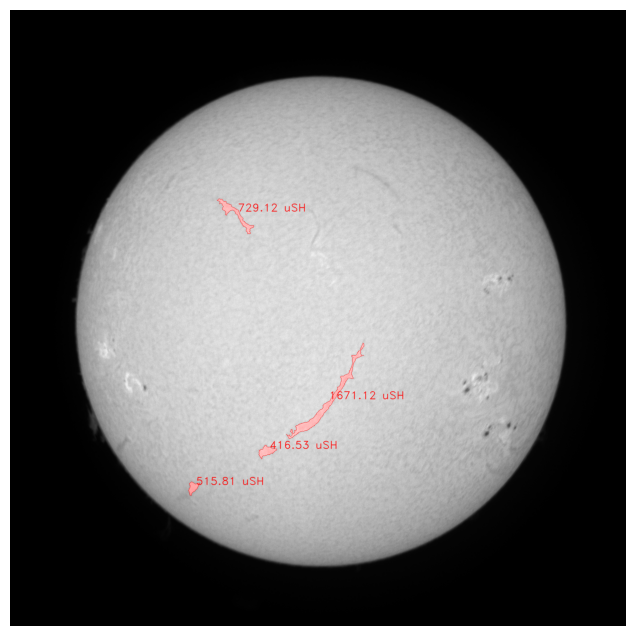

In [484]:
image = cv.convertScaleAbs(map.data, alpha=(255.0/65535.0)).astype(np.uint8)

# Colors
color = (255,0,0)
weight = np.max(image)/255.0

color_image = np.zeros((filaments.shape[0], filaments.shape[1], 3), dtype=np.uint8)
color_image[filaments==255] = [255,0,0]

img_label = cv.addWeighted(cv.cvtColor(image, cv.COLOR_GRAY2RGB), 1/weight, color_image, weight,0)

contours, _ = cv.findContours(filaments, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_label, contours, -1, color, 1)

# Numbers
font = cv.FONT_HERSHEY_DUPLEX
fontScale = 1.2
thickness = 1

img_num = img_label.copy()
for filament in table :
    cv.putText(img_num, str(filament['area']), (int(filament['x'].value) + 10, int(filament['y'].value) + 10), font, fontScale, color, thickness, cv.LINE_AA, True)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(img_num, origin='lower', cmap='grey');

### Example usage

In [3]:
from climso.detection import Filaments

In [4]:
filaments = Filaments(files[0])

In [5]:
filaments.table

number,latitude,longitude,x,y,area
,deg,deg,pix,pix,uSH
int32,float64,float64,float64,float64,float64
1,-42.47,-45.83,602.0,473.0,436.56
2,-30.89,-15.03,846.0,593.0,392.99
3,-17.66,1.51,1044.0,758.0,1587.64
4,-26.12,51.16,1581.0,659.0,285.33
5,28.32,-23.7,741.0,1382.0,702.6


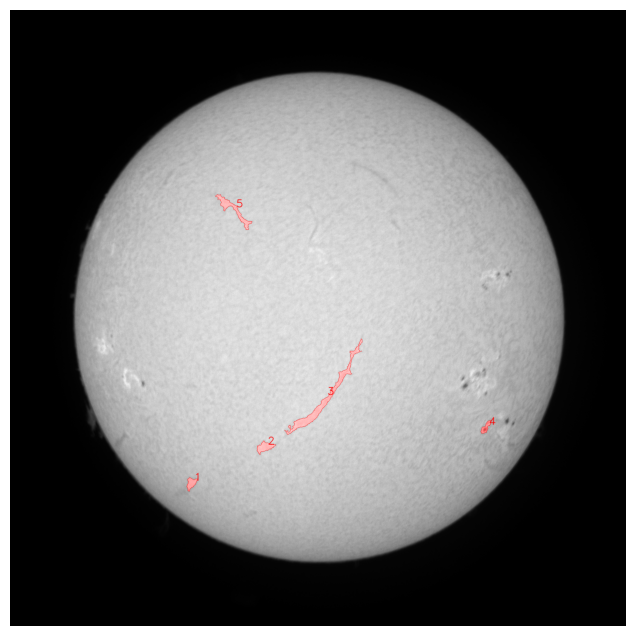

In [8]:
filaments.plot(cmap='inferno')